# Clustering time series using intermittent demand related features

Given that handling the intermitten demand is one of the main challanges of the competition I encountered some research publications that apply clustering to group time series according to intermitten demand characteristcis.
They use clustering to aggregate series and make the predictions on aggregated levels though I thought clustering may also help for this competition. I just clustered them quickly as below and will try to see whether there is any improvement by training different GBMs for different clusters. If someone has already tried, I would be really happy to hear about observed results.

Also, I think this intermittent demand related features can also help without clustering.


In [12]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt

In [8]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024 ** 2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024 ** 2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (
                start_mem - end_mem) / start_mem))
    return df

# this function copied from the below post -- Thanks to Warren Weckesser
# https://stackoverflow.com/questions/24885092/finding-the-consecutive-zeros-in-a-numpy-array
def zero_runs(a):
    # Create an array that is 1 where a is 0, and pad each end with an extra 0.
    iszero = np.concatenate(([0], np.equal(a, 0).view(np.int8), [0]))
    absdiff = np.abs(np.diff(iszero))
    # Runs start and end where absdiff is 1.
    ranges = np.where(absdiff == 1)[0].reshape(-1, 2)
    return ranges

def non_zero_runs(a):
    # Create an array that is 1 where a is 0, and pad each end with an extra 0.
    is_non_zero = np.concatenate(([0], np.greater(a, 0).view(np.int8), [0]))
    absdiff = np.abs(np.diff(is_non_zero))
    # Runs start and end where absdiff is 1.
    ranges = np.where(absdiff == 1)[0].reshape(-1, 2)
    return ranges


# Create Features of Intermittent Demand

In [9]:
TRAIN_LOC = "../input/m5-forecasting-accuracy/sales_train_validation.csv"

train = pd.read_csv(TRAIN_LOC)
train = reduce_mem_usage(train)
arr = np.array(train.iloc[:,6:])

X = {}
X["number_of_leading_zeros"] = np.argmax(np.array(train.iloc[:,6:] > 0), axis=1)

X["Number_of_zero_demands/1916"] = []

X["Decay_mean_zero_demand_length"] = []
X["Mean_zero_demand_length"] = []
X["Std_zero_demand_length"] = []
X["Max_zero_demand_length"] = []

X["Decay_mean_non_zero_demand_length"] = []
X["Mean_non_zero_demand_length"] = []
X["Std_non_zero_demand_length"] = []
X["Max_non_zero_demand_length"] = []

X["Decay_mean_sales_1day_before_zero"] = []
X["Mean_sales_1day_before_zero"] = []
X["Std_sales_1day_before_zero"] = []
X["Max_sales_1day_before_zero"] = []


for i,excld in enumerate(tqdm(X["number_of_leading_zeros"])):
    remaining = 1913 - excld
    series = arr[i,excld:]

    zero_demand_length = np.diff(zero_runs(series)).ravel()
    non_zero_demand_length = np.diff(non_zero_runs(series)).ravel()
    sales_1day_before_zero = series[(zero_runs(series)[:, 0] - 1)]

    X["Number_of_zero_demands/1916"].append(((series== 0).sum())/remaining)

    for i, serie in enumerate([zero_demand_length,non_zero_demand_length,sales_1day_before_zero]):
        if i == 0: name="zero_demand_length"
        if i == 1: name = "non_zero_demand_length"
        if i == 2: name = "sales_1day_before_zero"

        X["Decay_mean_%s"%name].append(np.ma.average(serie, weights=np.power(0.95, np.arange(len(serie), 0, -1))))
        X["Std_%s"%name].append(serie.std())
        X["Max_%s"%name].append(serie.max())

        if i == 2:
            X["Mean_%s" % name].append(serie.mean()/series.mean())
        else:
            X["Mean_%s" % name].append(serie.mean())


X = pd.DataFrame(X)
X = reduce_mem_usage(X)

Mem. usage decreased to 95.00 Mb (78.7% reduction)


100%|██████████| 30490/30490 [00:24<00:00, 1269.44it/s]


Mem. usage decreased to  0.81 Mb (75.0% reduction)


# Apply Transformation & PCA & Clustering

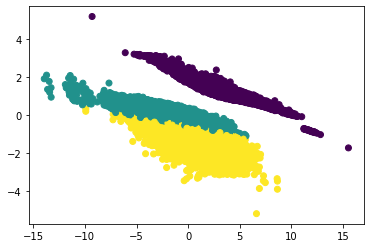

In [13]:
# Transform features to normal distribution
x = np.array(X)
quantile_transformer = preprocessing.QuantileTransformer(output_distribution='normal', random_state=0)
x = quantile_transformer.fit_transform(x)

# Apply PCA to gaussian like data
pca=PCA(n_components=2)
x2 = pca.fit_transform(x)
# Transforma again the second component of PCA to turn bimodel distribution into gaussian
x2[:,1] = quantile_transformer.fit_transform(x2[:,1].reshape((-1,1))).ravel()

# Expectation maximisation for clustering
gm=GaussianMixture(3)
gm_preds = gm.fit_predict(x2)

# Plot clusters on 2-d
plt.scatter(x2[:,0],x2[:,1], c=gm_preds)
plt.show()